In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import TFDistilBertModel, DistilBertTokenizer

c:\Users\andrian21\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
train_df = pd.read_csv('processed_train_df.csv')
train_df = train_df[['Entity', 'en_content', 'Sentiment']]
train_df.columns = ['Entity', 'Content', 'Sentiment']
train_df

,Entity,Content,Sentiment
0,Borderlands,"['i', 'am', 'coming', 'to', 'the', 'border', '...",Positive
1,Borderlands,"['i', 'am', 'getting', 'on', 'borderland', 'an...",Positive
2,Borderlands,"['i', 'am', 'coming', 'on', 'borderland', 'and...",Positive
3,Borderlands,"['i', 'am', 'getting', 'on', 'borderland', '2'...",Positive
4,Borderlands,"['i', 'am', 'getting', 'into', 'borderland', '...",Positive
...,...,...,...
51576,Nvidia,"['my', 'be', 'no', 'highlight', 'picture', 're...",Positive
51577,Nvidia,"['just', 'realized', 'that', 'my', 'mac', 'win...",Positive
51578,Nvidia,"['just', 'realized', 'the', 'window', 'partiti...",Positive
51579,Nvidia,"['just', 'realized', 'between', 'the', 'window...",Positive


In [7]:
test_df = pd.read_csv('processed_test_df.csv')
test_df = test_df[['Entity', 'en_content', 'Sentiment']]
test_df.columns = ['Entity', 'Content', 'Sentiment']
test_df

,Entity,Content,Sentiment
0,Amazon,"['broadcasting', 'corporation', 'news', 'amazo...",Neutral
1,Microsoft,"['why', 'do', 'i', 'pay', 'for', 'word', 'when...",Negative
2,CS-GO,"['matchmaking', 'is', 'so', 'full', 'of', 'clo...",Negative
3,Google,"['now', 'the', 'president', 'is', 'slapping', ...",Neutral
4,FIFA,"['hi', 'i', 'had', 'in', 'my', 'cellar', 'for'...",Negative
...,...,...,...
994,GrandTheftAuto(GTA),"['is', 'the', 'art', 'and', 'culture', 'capita...",Irrelevant
995,CS-GO,"['this', 'is', 'actually', 'a', 'good', 'move'...",Irrelevant
996,Borderlands,"['today', 'sucked', 'so', 'it', 's', 'time', '...",Positive
997,Microsoft,"['bought', 'a', 'fraction', 'of', 'today', 'sm...",Positive


In [8]:
from ast import literal_eval

def combine_list(entity, lst):
    actual_list = literal_eval(lst)
    str_list = ' '.join(actual_list)

    return f'{entity.lower()} : {str_list}'

train_df.loc[:, 'Content'] = train_df.apply(lambda x: combine_list(x['Entity'], x['Content']), axis=1)
test_df.loc[:, 'Content'] = test_df.apply(lambda x: combine_list(x['Entity'], x['Content']), axis=1)

In [9]:
from transformers import DistilBertTokenizer, TFDistilBertModel
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# # Load and preprocess the data
data_train = train_df[['Content', 'Sentiment']]
data_train['Sentiment_label'] = pd.Categorical(data_train['Sentiment'])
data_train['Sentiment'] = data_train['Sentiment_label'].cat.codes

# # Split the data into training and validation sets
data_val = test_df[['Content', 'Sentiment']]
data_val['Sentiment_label'] = pd.Categorical(data_val['Sentiment'])
data_val['Sentiment'] = data_val['Sentiment_label'].cat.codes

# Extract the training and validation texts and labels
train_texts = data_train['Content'].tolist()
train_labels = data_train['Sentiment'].tolist()
val_texts = data_val['Content'].tolist()
val_labels = data_val['Sentiment'].tolist()

# Tokenize the texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=64)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=64)

# Convert the labels to one-hot encoding
num_labels = len(data_train['Sentiment_label'].cat.categories)
train_labels_encoded = tf.one_hot(train_labels, num_labels)
val_labels_encoded = tf.one_hot(val_labels, num_labels)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels_encoded))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels_encoded))

# Define the model architecture
input_ids = tf.keras.layers.Input(shape=(64, ), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(64, ), dtype=tf.int32, name='attention_mask')
output = model(input_ids, attention_mask=attention_mask)[0]
output = tf.keras.layers.Dense(num_labels, activation='softmax')(output[:, 0, :])  # Pooling the output
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

# Compile and train the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-6)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)  # Set from_logits to False for softmax activation
metrics = ['accuracy']

# Define the ModelCheckpoint callback to save the best weights
checkpoint_filepath = 'distilbert.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Use smaller batch size
batch_size = 16
epochs = 10

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Train the model with early stopping and model checkpoint
history = model.fit(
    train_dataset.batch(batch_size),
    epochs=epochs,
    validation_data=val_dataset.batch(batch_size),
    callbacks=[model_checkpoint]
)

# Evaluate the model
model.evaluate(val_dataset.batch(batch_size))


tokenizer_config.json: 100%|██████████| 28.0/28.0 [00:00<00:00, 13.9kB/s]
c:\Users\andrian21\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\andrian21\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
vocab.txt: 100%|██████████| 232k/232k 


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/10


3224/3224 [==============================] - ETA: 0s - loss: 1.0922 - accuracy: 0.5333
Epoch 1: val_loss improved from inf to 1.08230, saving model to distilbert.h5


c:\Users\andrian21\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3224/3224 [==============================] - 2045s 632ms/step - loss: 1.0922 - accuracy: 0.5333 - val_loss: 1.0823 - val_accuracy: 0.6006
Epoch 2/10
3224/3224 [==============================] - ETA: 0s - loss: 0.9330 - accuracy: 0.6206
Epoch 2: val_loss improved from 1.08230 to 0.88052, saving model to distilbert.h5
3224/3224 [==============================] - 1952s 605ms/step - loss: 0.9330 - accuracy: 0.6206 - val_loss: 0.8805 - val_accuracy: 0.6637
Epoch 3/10
3224/3224 [==============================] - ETA: 0s - loss: 0.7982 - accuracy: 0.6824
Epoch 3: val_loss improved from 0.88052 to 0.69032, saving model to distilbert.h5
3224/3224 [==============================] - 1925s 597ms/step - loss: 0.7982 - accuracy: 0.6824 - val_loss: 0.6903 - val_accuracy: 0.7477
Epoch 4/10
3224/3224 [==============================] - ETA: 0s - loss: 0.6538 - accuracy: 0.7462
Epoch 4: val_loss improved from 0.69032 to 0.53926, saving model to distilbert.h5
3224/3224 [==============================] - 1

[0.24237802624702454, 0.9369369149208069]

16/16 [==============================] - 3s 183ms/step
Validation Set - Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.93      0.91      0.92       171
    Negative       0.97      0.94      0.96       266
     Neutral       0.92      0.95      0.93       285
    Positive       0.93      0.94      0.93       277

    accuracy                           0.94       999
   macro avg       0.94      0.93      0.94       999
weighted avg       0.94      0.94      0.94       999

Validation Set - Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.93      0.91      0.92       171
    Negative       0.97      0.94      0.96       266
     Neutral       0.92      0.95      0.93       285
    Positive       0.93      0.94      0.93       277

    accuracy                           0.94       999
   macro avg       0.94      0.93      0.94       999
weighted avg       0.94      0.94      0.94     

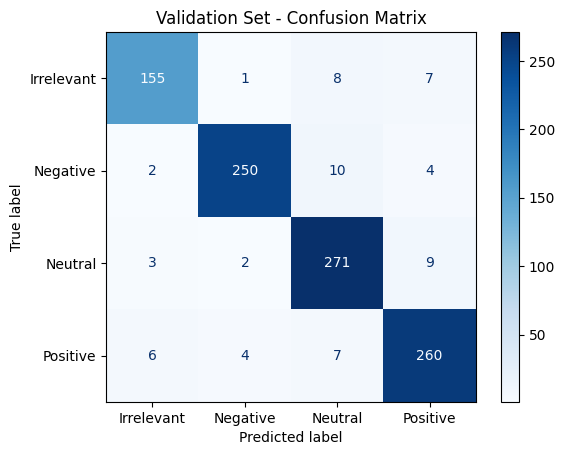

Test Set - Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.94      0.85      0.89       171
    Negative       0.92      0.89      0.91       266
     Neutral       0.83      0.92      0.87       285
    Positive       0.89      0.87      0.88       277

    accuracy                           0.89       999
   macro avg       0.89      0.88      0.89       999
weighted avg       0.89      0.89      0.89       999



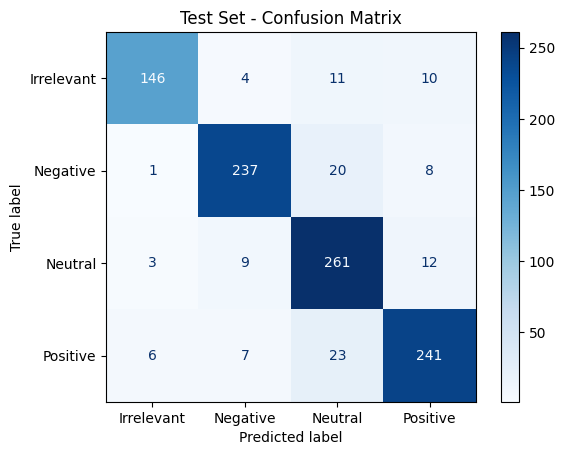

In [11]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import os
import matplotlib.pyplot as plt

# Load and preprocess the data
data_test = test_df[['Content', 'Sentiment']]
data_test['Sentiment_label'] = pd.Categorical(data_test['Sentiment'])
data_test['Sentiment'] = data_test['Sentiment_label'].cat.codes

test_texts = data_test['Content'].tolist()
test_labels = data_test['Sentiment'].tolist()

test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=24)

# Convert the labels to one-hot encoding
num_labels = len(data_val['Sentiment_label'].cat.categories)
val_labels_encoded = tf.one_hot(val_labels, num_labels)
test_labels_encoded = tf.one_hot(test_labels, num_labels)

# Create TensorFlow datasets
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels_encoded))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels_encoded))

val_predictions = model.predict(val_dataset.batch(64))
val_predicted_labels = np.argmax(val_predictions, axis=1)
test_predictions = model.predict(test_dataset.batch(64))
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Convert the predicted labels to their original sentiment categories
val_predicted_sentiments = data_val['Sentiment_label'].cat.categories[val_predicted_labels]
test_predicted_sentiments = data_test['Sentiment_label'].cat.categories[test_predicted_labels]

# Convert the true labels to their original sentiment categories
val_true_labels = data_val['Sentiment_label']
test_true_labels = data_test['Sentiment_label']

# Calculate the classification report for the validation set
val_classification_rep = classification_report(val_true_labels, val_predicted_sentiments)
print("Validation Set - Classification Report:\n", val_classification_rep)

# Generate the confusion matrix for the valing set
val_confusion_mat = confusion_matrix(val_true_labels, val_predicted_sentiments)

# Get the unique labels/categories from the true labels
labels = np.unique(val_true_labels)


save_folder = 'Distilbert'
os.makedirs(save_folder, exist_ok=True)

val_classification_rep = classification_report(val_true_labels, val_predicted_sentiments)
print("Validation Set - Classification Report:\n", val_classification_rep)

val_report_path = os.path.join(save_folder, 'validation_classification_report.txt')
with open(val_report_path, 'w') as file:
    file.write("Validation Set - Classification Report:\n")
    file.write(val_classification_rep)

# Plot the confusion matrix for the validation set
val_display = ConfusionMatrixDisplay(confusion_matrix=val_confusion_mat, display_labels=labels)
val_display.plot(cmap='Blues')
plt.title("Validation Set - Confusion Matrix")
plt.grid(False)
val_image_path = os.path.join(save_folder, 'validation_confusion_matrix.png')
plt.savefig(val_image_path)
plt.show()

# Calculate the classification report for the test set
test_classification_rep = classification_report(test_true_labels, test_predicted_sentiments)
print("Test Set - Classification Report:\n", test_classification_rep)

# Save the classification report for the test set to a file
test_report_path = os.path.join(save_folder, 'test_classification_report.txt')
with open(test_report_path, 'w') as file:
    file.write("Test Set - Classification Report:\n")
    file.write(test_classification_rep)


# Generate the confusion matrix for the test set
test_confusion_mat = confusion_matrix(test_true_labels, test_predicted_sentiments)


# Plot the confusion matrix for the test set
test_display = ConfusionMatrixDisplay(confusion_matrix=test_confusion_mat, display_labels=labels)
test_display.plot(cmap='Blues')
plt.title("Test Set - Confusion Matrix")
plt.grid(False)
test_image_path = os.path.join(save_folder, 'test_confusion_matrix.png')
plt.savefig(test_image_path)
plt.show()